In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
import scipy.stats as ss
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import random 
import statsmodels.tsa.stattools as ts
import warnings
from arch.unitroot import PhillipsPerron, VarianceRatio
import statsmodels.api as sm
from mlfinlab.labeling.trend_scanning import trend_scanning_labels
from collections import defaultdict
import yfinance as yf

In [2]:
prices = pd.read_csv("sample_US_equity_close.csv", index_col=0)
sample = 200
sample_securities = prices.columns[:sample]

train = prices[:'2018'][sample_securities]
test = prices['2018':][sample_securities]

penny_stock_price = 5
train = train[train>penny_stock_price].dropna(axis=1)
test = test[test>penny_stock_price].dropna(axis=1)
securities = train.columns
n_securities = len(securities)
train.head()

,UVSP,CBSH,MMLP,LOGN,CRDF,CUB,CZNC,TILE,KLAC,GLT,...,HIFS,AXP,LFUS,STRS,FMX,PRFT,DTE,GIS,CCU,MET
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,17.75,26.586,31.990,12.4,328.319,39.15,9.65,8.66,36.92,12.68,...,30.56,40.92,33.58,11.29,49.90,8.70,43.54,35.45,15.712,36.30
2010-01-05,16.86,26.539,32.370,12.4,323.999,41.58,9.55,8.56,36.51,13.18,...,30.50,40.83,32.42,11.00,48.71,8.61,43.05,35.12,15.748,37.14
2010-01-06,16.78,26.437,32.720,12.4,319.679,41.02,9.27,8.34,36.37,13.22,...,32.73,41.49,32.37,10.38,49.39,8.58,43.23,35.33,16.004,37.52
2010-01-07,17.12,27.060,32.950,12.4,323.999,40.26,9.03,8.43,36.57,13.22,...,32.73,41.98,32.38,9.64,50.01,8.54,42.83,35.65,16.264,38.05
2010-01-08,17.17,26.722,32.839,12.4,323.999,40.76,9.23,8.48,37.12,13.62,...,32.75,41.95,32.65,9.39,49.77,8.56,43.16,35.36,16.556,38.25


In [3]:
pairs = list(combinations(securities, 2))
def convertTuple(tup): 
    string =  '-'.join(tup) 
    return string

def convertString(string):
    security_list = string.split('-')
    return security_list

pairs_list = []
for pair in pairs:
    pairs_list.append(convertTuple(pair))

In [4]:
### Lopez de Prado Machine Learning for Asset Management

def numBins(nObs,corr=None):
    # Optimal number of bins for discretization 
    if corr is None: # univariate case
        z=(8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b=round(z/6.+2./(3*z)+1./3) 
    else: # bivariate case
        b=round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)
    return int(b)

def mutualInfo(x,y,norm=False):
    # mutual information
    bXY=numBins(x.shape[0], corr=np.corrcoef(x,y)[0,1])
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    if norm:
        hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal 
        hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal 
        iXY/=min(hX,hY) # normalized mutual information
    return iXY

In [5]:
try:
    mutual_info_df = pd.read_csv(f'mutual_info_{n_securities}.csv', index_col=0)
    print('mutual_info_df loaded')
except FileNotFoundError:
    print('Generating mutual_info_df')
    mutual_info_list = []
    for i in range(len(pairs)):
        security_0 = train[pairs[i][0]]
        security_1 = train[pairs[i][1]]
        temp = mutualInfo(security_0, security_1, True)
        mutual_info_list.append(temp)
        
    mutual_info_df = pd.DataFrame({'mutual_information':mutual_info_list},
                                  index=pairs_list)
    mutual_info_df.sort_values(by='mutual_information')
    mutual_info_df.to_csv(f'mutual_info_{n_securities}.csv')

mutual_info_df loaded


In [6]:
top_quantile = mutual_info_df.quantile(0.9)
potential_pairs = mutual_info_df[mutual_info_df >= top_quantile].dropna()
potential_pairs

,mutual_information
UVSP-INDB,0.490203
UVSP-STL,0.495971
CBSH-LOGN,0.495477
CBSH-INDB,0.569083
CBSH-FFDF,0.506975
...,...
AXP-LFUS,0.507608
LFUS-DTE,0.561088
LFUS-GIS,0.494138
STRS-DTE,0.489743


In [7]:
# https://austinrochford.com/posts/2013-12-12-polynomial-regression-cross-validation.html

class PolynomialRegression(BaseEstimator):
    def __init__(self, deg=None):
        self.deg = deg
    
    def fit(self, X, y, deg=None):
        self.model = LinearRegression(fit_intercept=False)
        self.model.fit(np.vander(X, N=self.deg + 1), y)
    
    def predict(self, x):
        return self.model.predict(np.vander(x, N=self.deg + 1))
    
    @property
    def coef_(self):
        return self.model.coef_

In [8]:
try:
    pass
    cv_models = pd.read_csv(f'cv_models_{n_securities}.csv', index_col=0)
    cv_predicted = pd.read_csv(f'cv_predicted_{n_securities}.csv', index_col=0)
    cv_spreads = pd.read_csv(f'cv_spreads_{n_securities}.csv', index_col=0)
    print('cv_models loaded')
    print('cv_spreads loaded')
except FileNotFoundError:
    print('Generating cv_models')
    best_params = []
    best_estimator = []
    best_predicted = []
    best_spread = []

    for i in range(len(pairs)):
        security_x = train[pairs[i][0]]
        security_y = train[pairs[i][1]]
        estimator = PolynomialRegression()
        degrees = np.arange(1, 5)
        cv_model = GridSearchCV(estimator,
                                param_grid={'deg': degrees},
                                scoring='neg_mean_squared_error',
                                cv=5)
        temp_model = cv_model.fit(security_x, security_y)
        temp_params = temp_model.best_params_['deg']
        temp_estimator = temp_model.best_estimator_.coef_
        temp_predicted = temp_model.predict(security_x)
        temp_spread = (security_y - temp_predicted).values
        best_params.append(temp_params)
        best_estimator.append(temp_estimator)
        best_predicted.append(temp_predicted)
        best_spread.append(temp_spread)
        if i*100 % len(pairs) == 0:
            print(i/len(pairs))

    cv_predicted = np.array(best_predicted).T
    cv_predicted = pd.DataFrame(cv_predicted,
                                columns=pairs_list,
                                index=train.index)
    cv_models = pd.DataFrame({'deg':best_params,
                         'estimates':best_estimator},
                        index=pairs_list)

    normalize = StandardScaler()
    cv_spreads = np.array(best_spread).T
    cv_spreads = pd.DataFrame(cv_spreads,
                             columns=pairs_list,
                             index=train.index)
    cv_spreads_norm = normalize.fit_transform(cv_spreads)
    cv_spreads_norm = pd.DataFrame(cv_spreads_norm,
                            columns=pairs_list,
                            index=train.index)
    cv_spreads.head()
    cv_models.to_csv(f'cv_models_{n_securities}.csv')
    cv_predicted.to_csv(f'cv_predicted_{n_securities}.csv')
    cv_spreads.to_csv(f'cv_spreads_{n_securities}.csv')
    print('cv_models written')
    print('cv_cv_predicted written')
    print('cv_spreads written')

cv_models loaded
cv_spreads loaded


In [9]:
cv_models.head()

,deg,estimates
UVSP-CBSH,1,[ 1.94362424 -2.44337494]
UVSP-MMLP,2,[-0.06430275 1.54301734 27.39386505]
UVSP-LOGN,1,[ 1.83085807 -11.02537447]
UVSP-CRDF,1,[-13.37843755 571.17246945]
UVSP-CUB,1,[ 0.32248718 40.04029821]


In [10]:
cv_spreads.head()

,UVSP-CBSH,UVSP-MMLP,UVSP-LOGN,UVSP-CRDF,UVSP-CUB,UVSP-CZNC,UVSP-TILE,UVSP-KLAC,UVSP-GLT,UVSP-TRNX,...,PRFT-DTE,PRFT-GIS,PRFT-CCU,PRFT-MET,DTE-GIS,DTE-CCU,DTE-MET,GIS-CCU,GIS-MET,CCU-MET
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-5.469955,-2.533039,-9.072356,-5.386203,-6.614446,-8.097322,-7.427490,-14.824462,-6.013373,-14448.296733,...,-4.548454,-1.322299,-7.031892,3.605726,-0.528840,-7.235417,-1.955919,-3.407857,-5.189377,-5.669156
2010-01-05,-3.787130,-2.760465,-7.442893,-21.613012,-3.897432,-7.704266,-7.148991,-11.847838,-4.168264,-14968.289865,...,-5.109662,-1.666730,-6.931208,4.739750,-0.861461,-7.188173,-1.000974,-2.463249,-5.434815,-4.878110
2010-01-06,-3.733640,-2.460075,-7.296424,-27.003287,-4.431633,-7.939946,-7.334969,-11.683422,-3.999547,-15149.862281,...,-4.958124,-1.463437,-6.653416,5.218298,-0.648933,-6.936304,-0.663198,-2.792046,-4.351401,-4.838604
2010-01-07,-3.771472,-2.013547,-7.918916,-18.134619,-5.301279,-8.368305,-7.389564,-12.777189,-4.537724,-11378.179512,...,-5.399783,-1.153868,-6.364180,5.880116,-0.337040,-6.667125,-0.039366,-3.379093,-2.834167,-4.640741
2010-01-08,-4.206653,-2.091451,-8.010459,-17.465697,-4.817403,-8.196004,-7.360828,-12.417449,-4.214909,-11264.696752,...,-5.048422,-1.438439,-6.086824,6.014147,-0.619699,-6.382697,0.083222,-2.321699,-3.524550,-4.797323


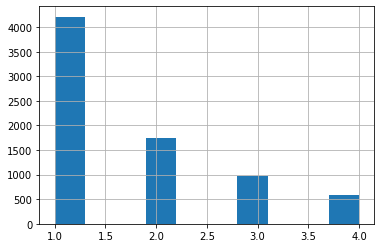

In [11]:
cv_models['deg'].hist()

In [12]:
def hurst(norm_spread):
    """
    Calculates Hurst exponent.
    https://en.wikipedia.org/wiki/Hurst_exponent

    :param norm_spread: An array like object used to calculate half-life.
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    diffs = [np.subtract(norm_spread[l:], norm_spread[:-l]) for l in lags]
    tau = [np.sqrt(np.std(diff)) for diff in diffs]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    H = poly[0]*2.0

    return H


In [13]:
def half_life(norm_spread):
    """
    Calculates time series half-life.
    https://en.wikipedia.org/wiki/Half-life

    :param norm_spread: An array like object used to calculate half-life.
    """
    lag = norm_spread.shift(1)
    lag[0] = lag[1]

    ret = norm_spread - lag
    lag = sm.add_constant(lag)

    model = sm.OLS(ret, lag)
    result = model.fit()
    half_life = -np.log(2)/result.params.iloc[1]

    return half_life

In [14]:
try:
    cv_test_stats = pd.read_csv(f'cv_test_stats_{n_securities}.csv', index_col=0)
    print('cv_test_stats loaded')
except FileNotFoundError:
    print('calculating cv_test_stats')
    hurst_exponents = []
    for col in cv_spreads.columns:
        hurst_exp = hurst(cv_spreads[col].values)
        hurst_exponents.append(hurst_exp)

    cv_hurst_exponents = pd.DataFrame({'hurst_exponent':hurst_exponents}, index=pairs_list)
    adfuller_t = []
    adfuller_p = []
    kpss_t = []
    kpss_p = []
    pp_t = []
    pp_p = []
    vr_t = []
    vr_p = []

    warnings.filterwarnings('ignore')
    for i in range(len(pairs)):
        temp_spread = cv_spreads.iloc[:, i]

        temp_adfuller = ts.adfuller(temp_spread)
        temp_adfuller_t = temp_adfuller[0]
        temp_adfuller_p = temp_adfuller[1]

        temp_kpss = ts.kpss(temp_spread)
        temp_kpss_t = temp_kpss[0]
        temp_kpss_p = temp_kpss[1]

        temp_pp = PhillipsPerron(temp_spread)
        temp_pp_t = temp_pp.stat
        temp_pp_p = temp_pp.pvalue

        temp_vr = VarianceRatio(temp_spread)
        temp_vr_t = temp_vr.stat
        temp_vr_p = temp_vr.pvalue

        adfuller_t.append(temp_adfuller_t)
        adfuller_p.append(temp_adfuller_p)

        kpss_t.append(temp_kpss_t)
        kpss_p.append(temp_kpss_p)

        pp_t.append(temp_pp_t)
        pp_p.append(temp_pp_p)

        vr_t.append(temp_vr_t)
        vr_p.append(temp_vr_p)

        if i*100 % len(pairs) == 0:
            print(i/len(pairs))

    cv_stationary_tests = pd.DataFrame({'adf_t_stat':adfuller_t,
                                        'adf_p_value':adfuller_p,
                                        'kpss_t_stat':kpss_t,
                                        'kpss_p_value':kpss_p,
                                        'pp_t_stat':pp_t,
                                        'pp_p_value':pp_p,
                                        'vr_t_stat':vr_t,
                                        'vr_p_value':vr_p},
                                       index=pairs_list)
    cv_test_stats = pd.concat([cv_half_lives, cv_hurst_exponents, cv_stationary_tests], axis=1)
    print('writing cv_test_stats')
    cv_test_stats.to_csv(f'cv_test_stats_{n_securities}.csv')
cv_test_stats.head()

cv_test_stats loaded


,half_life,hurst_exponent,adf_t_stat,adf_p_value,kpss_t_stat,kpss_p_value,pp_t_stat,pp_p_value,vr_t_stat,vr_p_value
UVSP-CBSH,55.300165,0.363306,-3.053893,0.030159,2.914898,0.010000,-3.178196,0.021282,-2.213335,0.026875
UVSP-MMLP,101.728446,0.420240,-2.588079,0.095486,1.078228,0.010000,-2.418629,0.136547,0.890366,0.373270
UVSP-LOGN,72.797717,0.379073,-2.484062,0.119400,3.553208,0.010000,-2.763957,0.063610,-3.214672,0.001306
UVSP-CRDF,78.537596,0.446873,-2.529775,0.108397,1.791241,0.010000,-2.635694,0.085842,-2.815759,0.004866
UVSP-CUB,57.430441,0.417367,-3.292806,0.015203,0.534826,0.033823,-3.282312,0.015688,-2.180892,0.029191


In [15]:
# import multiprocessing

# def calculate_stationarity_tests(enumerated_spread, 
#                                  pairs_list=pairs_list):
#     i, spread = enumerated_spread
#     pair = pairs_list[i]
        
#     adfuller = ts.adfuller(spread)
#     adfuller_t = temp_adfuller[0]
#     adfuller_p = temp_adfuller[1]
    
#     kpss = ts.kpss(spread)
#     kpss_t = temp_kpss[0]
#     kpss_p = temp_kpss[1]
    
#     pp = PhillipsPerron(spread)
#     pp_t = temp_pp.stat
#     pp_p = temp_pp.pvalue
    
#     vr = VarianceRatio(spread)
#     vr_t = temp_vr.stat
#     vr_p = temp_vr.pvalue
    
#     results = [adfuller_t, adfuller_p,
#               kpss_t, kpss_p,
#               pp_t, pp_p,
#               vr_t, vr_p]
    
#     return pair, results

# pool = multiprocessing.Pool()
# stationarity_map = pool.map(calculate_stationarity_tests, enumerate(best_spread[:5]))
# stationarity_dict = defaultdict(list)
# for pair, result in (r for r in stationarity_map):
#     stationarity_dict[pair] = result
# stationarity_map.close()
# stationarity_map.join()

# stationarity_dict
    
# # #
# # test_dict = defaultdict(list)

# # # pd.DataFrame.from_records(test_tup)
# # for i, spread in enumerate(best_spread):
# #     test_dict[pairs_list[i]] = spread[:5]
# # test_dict
# # #        print(i, spread[:5])

In [16]:
alpha_value = 0.05
mean_reversion_value = 0.5
min_half_life = 1.
max_half_life = 252.
cv_filtered = cv_test_stats[(cv_test_stats['kpss_p_value'] >= alpha_value) &
                            (cv_test_stats['adf_p_value'] < alpha_value) &
                            (cv_test_stats['pp_p_value'] < alpha_value) &
                            (cv_test_stats['vr_p_value'] < alpha_value) &
                            ((cv_test_stats['half_life'] >= min_half_life) & 
                            (cv_test_stats['half_life'] <= max_half_life )) &
                            (cv_test_stats['hurst_exponent'] < mean_reversion_value)]
filtered_pairs = cv_filtered.index
cv_filtered


,half_life,hurst_exponent,adf_t_stat,adf_p_value,kpss_t_stat,kpss_p_value,pp_t_stat,pp_p_value,vr_t_stat,vr_p_value
UVSP-TRNX,49.667619,0.465018,-3.145605,0.023357,0.359095,0.094786,-3.573156,6.295456e-03,-2.245408,0.024742
CBSH-CRDF,38.513788,0.441110,-3.950323,0.001694,0.228755,0.100000,-4.093061,9.944208e-04,-2.549768,0.010779
CBSH-SATS,30.084106,0.334912,-4.273244,0.000494,0.340909,0.100000,-4.626823,1.152369e-04,-3.681936,0.000231
CBSH-WNEB,24.967851,0.398388,-4.583345,0.000139,0.444468,0.057988,-5.013928,2.082682e-05,-4.354947,0.000013
CBSH-CSL,36.132802,0.406809,-3.984161,0.001496,0.423946,0.066834,-4.226249,5.946364e-04,-3.983537,0.000068
...,...,...,...,...,...,...,...,...,...,...
DWAHY-STRS,56.686661,0.494130,-3.101271,0.026459,0.299674,0.100000,-3.219536,1.888133e-02,-3.355856,0.000791
YORW-COHU,44.137313,0.381996,-3.510912,0.007711,0.338829,0.100000,-3.522946,7.416971e-03,-2.843892,0.004457
YORW-TENX,15.646158,0.323447,-4.587354,0.000136,0.273939,0.100000,-6.817557,2.040757e-09,-3.009257,0.002619
YORW-STRS,29.373084,0.397706,-3.881125,0.002178,0.228889,0.100000,-4.452951,2.389338e-04,-3.840481,0.000123


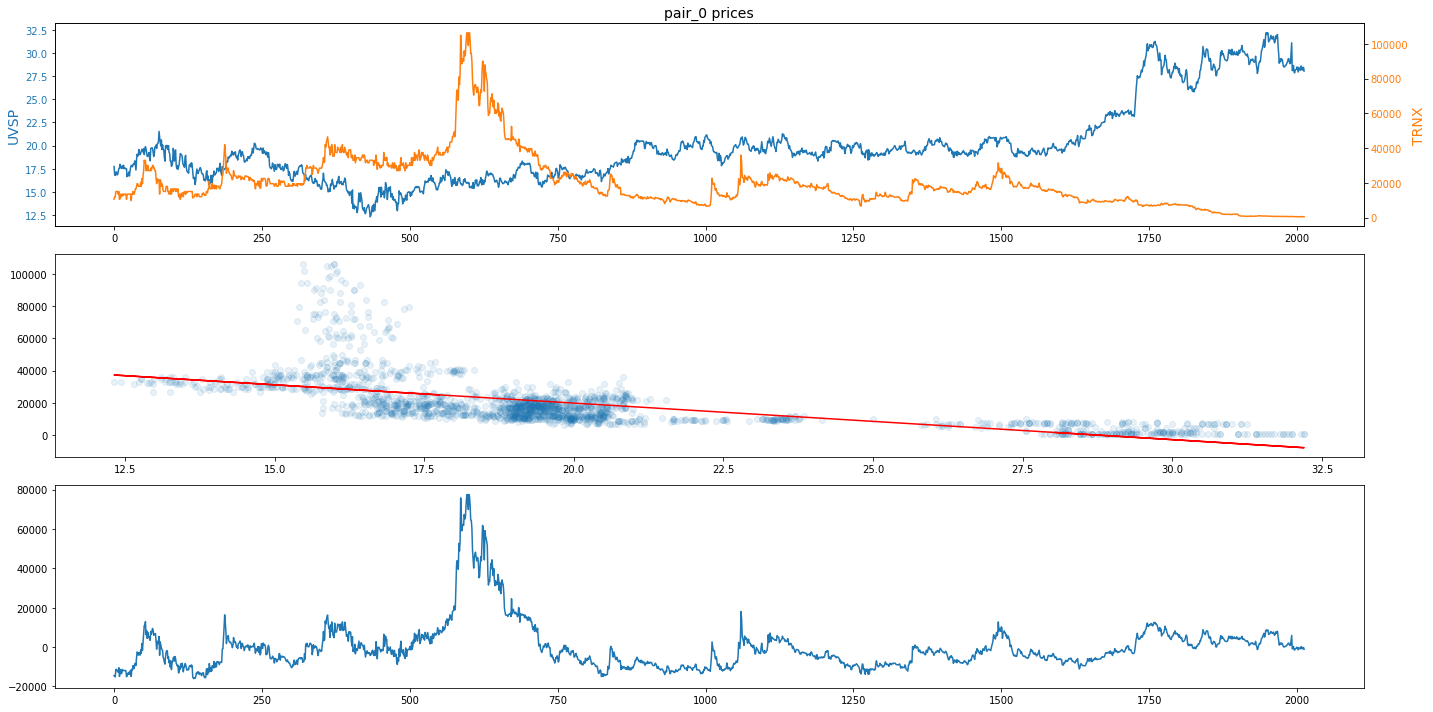

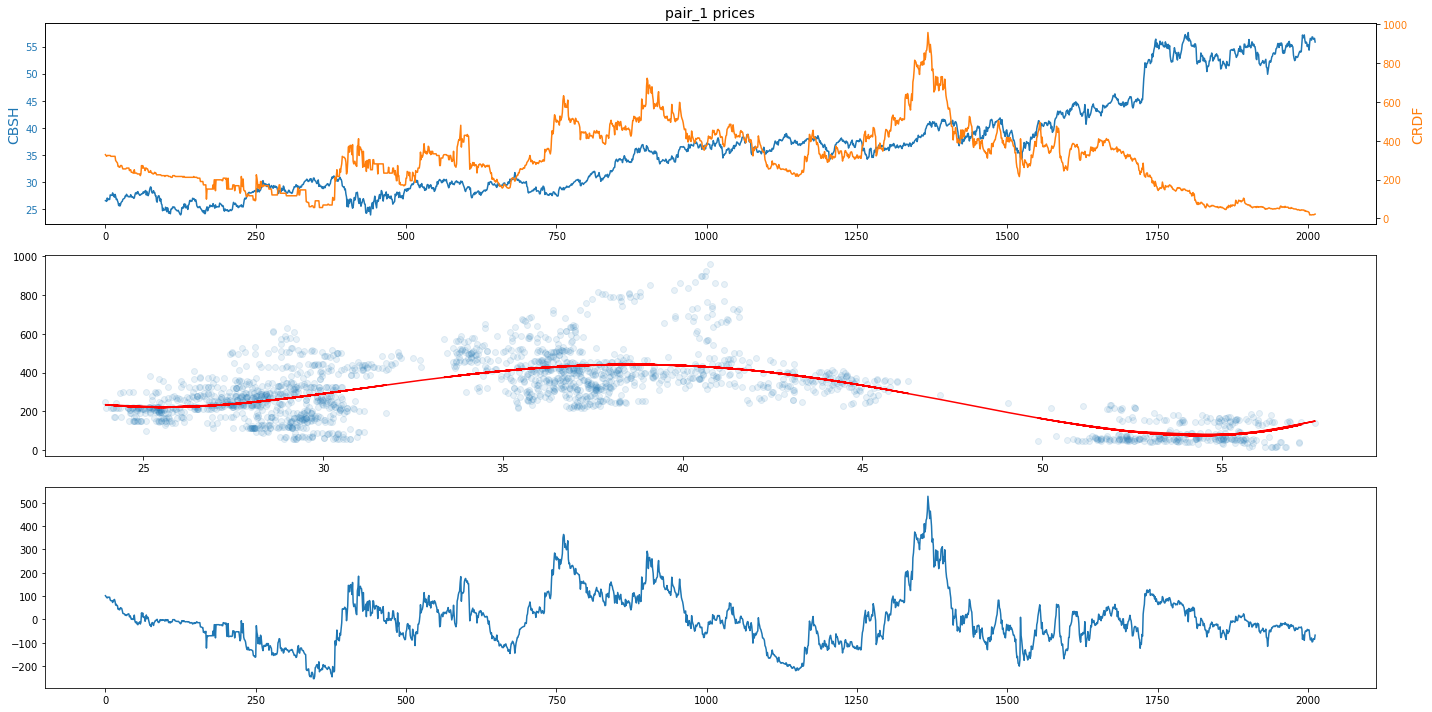

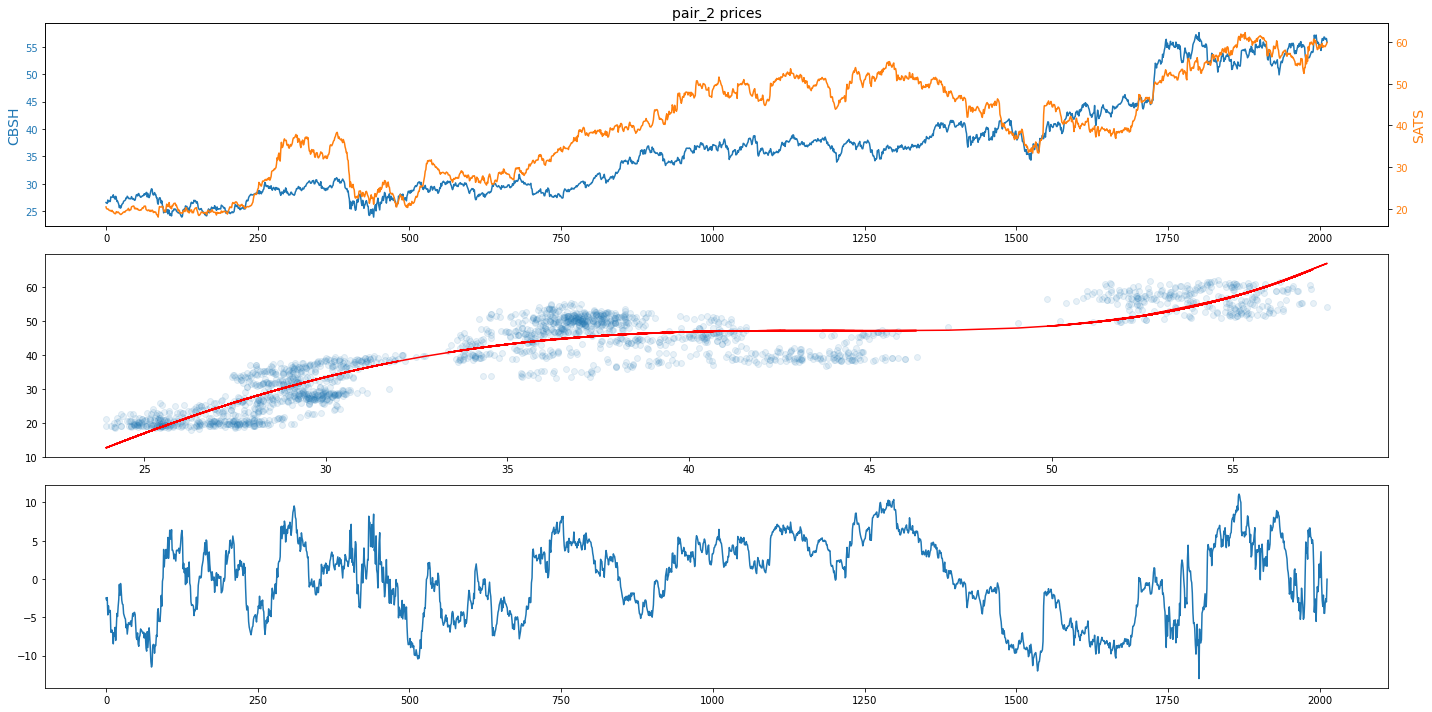

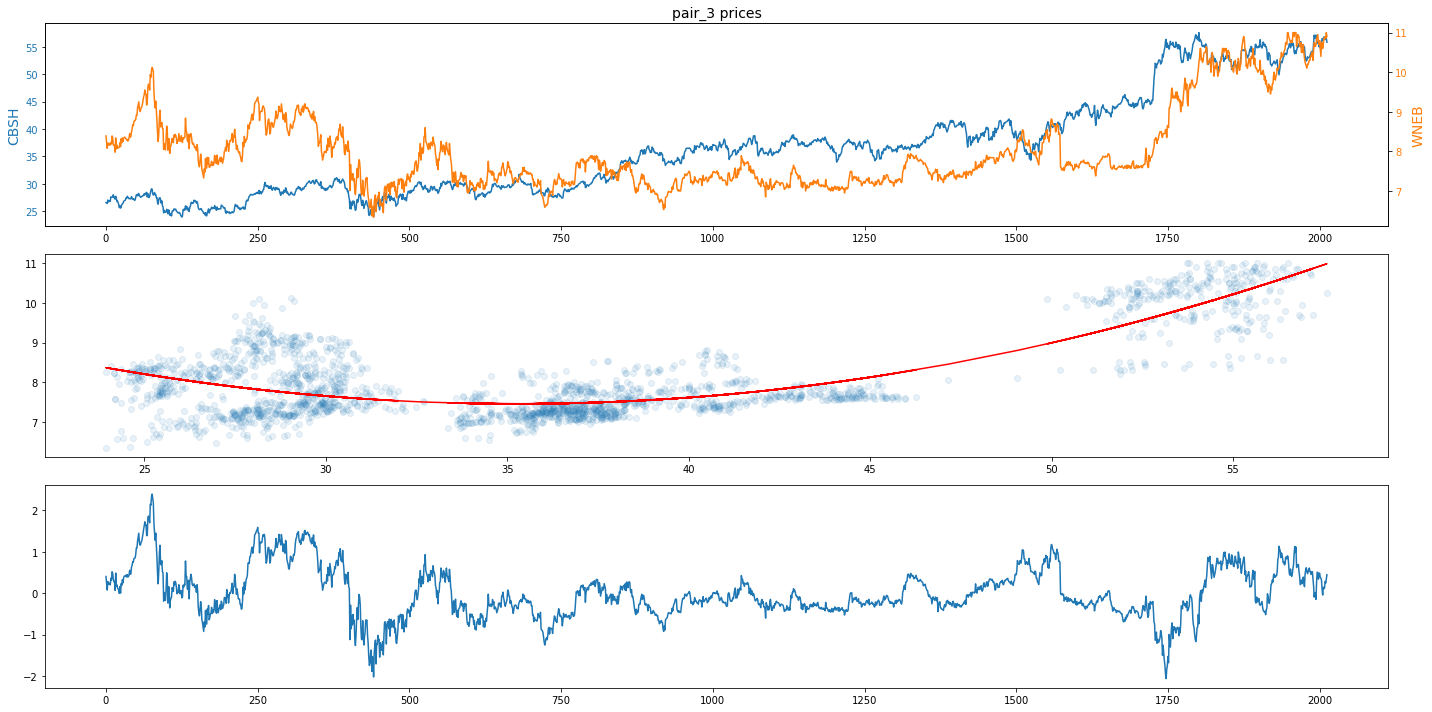

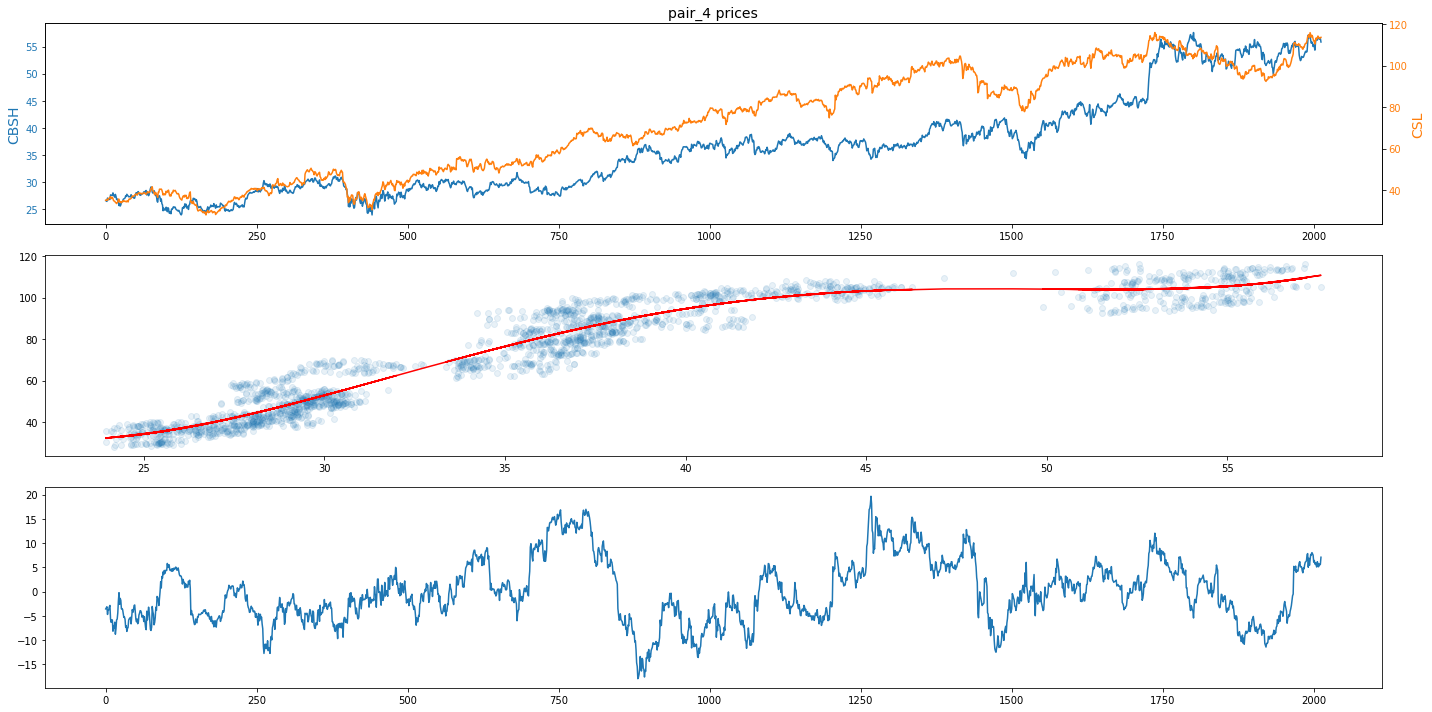

In [17]:
for i in range(len(cv_filtered[:5])):
    idx = i
    fontsize=14
    securities = convertString(cv_filtered.index[idx])

    fig, axs = plt.subplots(3, 1, sharex=False, figsize=(20, 10))
#     first security (left axis)
    security = securities[0]
    color = 'tab:blue'
    axs[0].plot(train[security].values, color=color)
    axs[0].set_ylabel(security, color=color, fontsize=fontsize)
    axs[0].tick_params(axis='y', labelcolor=color)
    axs[0].set_title('pair_'+str(idx)+' prices', fontsize=fontsize)

    security = securities[1]
    color = 'tab:orange'
    axs2 = axs[0].twinx()
    axs2.plot(train[security].values, color=color)
    axs2.set_ylabel(security, color=color, fontsize=fontsize)
    axs2.tick_params(axis='y', labelcolor=color)
    
    axs[1].plot(train[securities[0]].values, cv_predicted[convertTuple(securities)].values, 'r')
    axs[1].scatter(train[securities[0]].values, train[securities[1]].values, alpha=0.1)
    
    axs[2].plot(cv_spreads[convertTuple(securities)].values)
    
    fig.tight_layout()

In [18]:
try:
    cv_trend_stats = pd.read_csv(f'cv_trend_stats_{n_securities}.csv',
                                 index_col=[0,1], skipinitialspace=True)
    
    print('cv_trend_stats loaded')
except FileNotFoundError:
    securities = cv_filtered.index[0]
    test = trend_scanning_labels(cv_spreads[securities], look_forward=False)

    trend_t1 = test['t1'].values.T
    trend_t_value = test['t_value'].values.T
    trend_ret = test['ret'].values.T
    trend_bin = test['bin'].values.T

    for i in range(1, len(cv_filtered)):
        idx = i
        securities = cv_filtered.index[idx]
        test = trend_scanning_labels(cv_spreads[securities], look_forward=False)

        temp_t1 = test['t1'].values.T
        temp_t_value = test['t_value'].values.T
        temp_ret = test['ret'].values.T
        temp_bin = test['bin'].values.T

        trend_t1 = np.hstack([trend_t1, temp_t1])
        trend_t_value = np.hstack([trend_t_value, temp_t_value])
        trend_ret = np.hstack([trend_ret, temp_ret])
        trend_bin = np.hstack([trend_bin, temp_bin])

        if i*100 % len(cv_filtered) == 0:
            print(i/len(cv_filtered))
    dates = cv_spreads.index
    filtered_pairs = cv_filtered.index
    index = pd.MultiIndex.from_product([filtered_pairs, dates],
                                       names=['pair', 'date'])
    cv_trend_stats = pd.DataFrame({'t1':trend_t1,
                                   't_value':trend_t_value,
                                   'ret':trend_ret,
                                   'bin':trend_bin},
                                  index=index)
    cv_trend_stats = cv_trend_stats.swaplevel(0,1).sort_index(0)
    cv_trend_stats.to_csv(f'cv_trend_stats_{n_securities}.csv')
cv_trend_stats.tail()

cv_trend_stats loaded


t1   t_value       ret  bin
date       pair                                          
2017-12-29 WSBC-SNN   2017-12-28 -3.163124  0.613266 -1.0
           WSBC-TENX  2017-12-12 -2.848456  0.128816 -1.0
           YORW-COHU  2017-12-28  4.329503 -0.028469  1.0
           YORW-STRS  2017-12-12 -3.992631 -0.077764 -1.0
           YORW-TENX  2017-12-28 -3.106244 -0.027841 -1.0

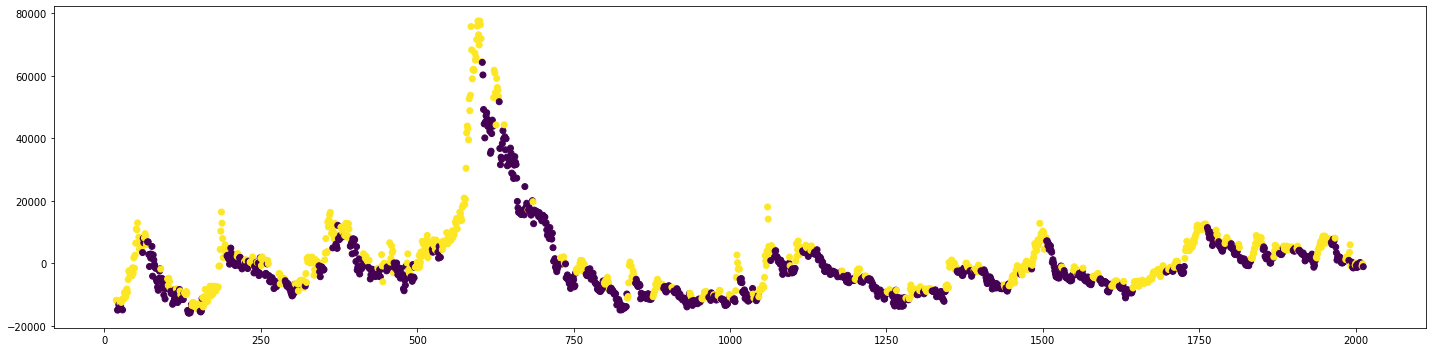

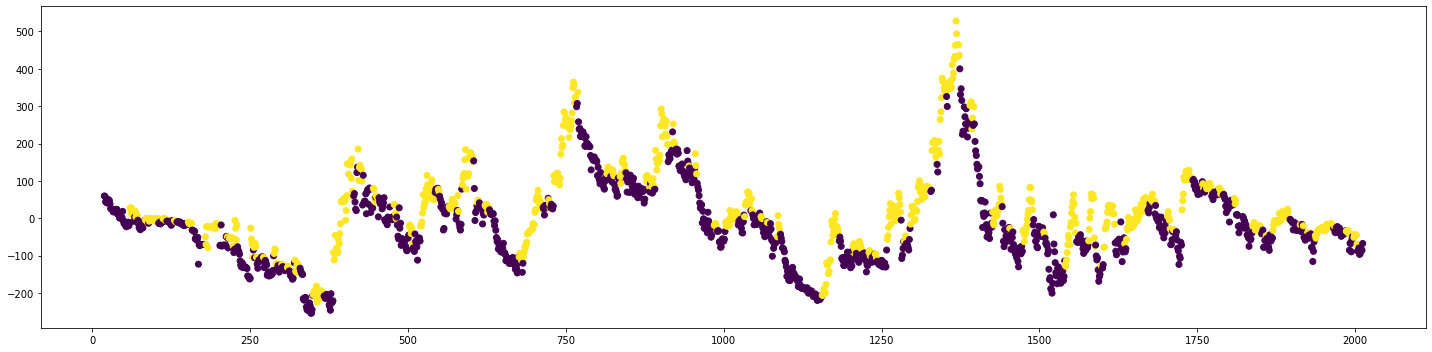

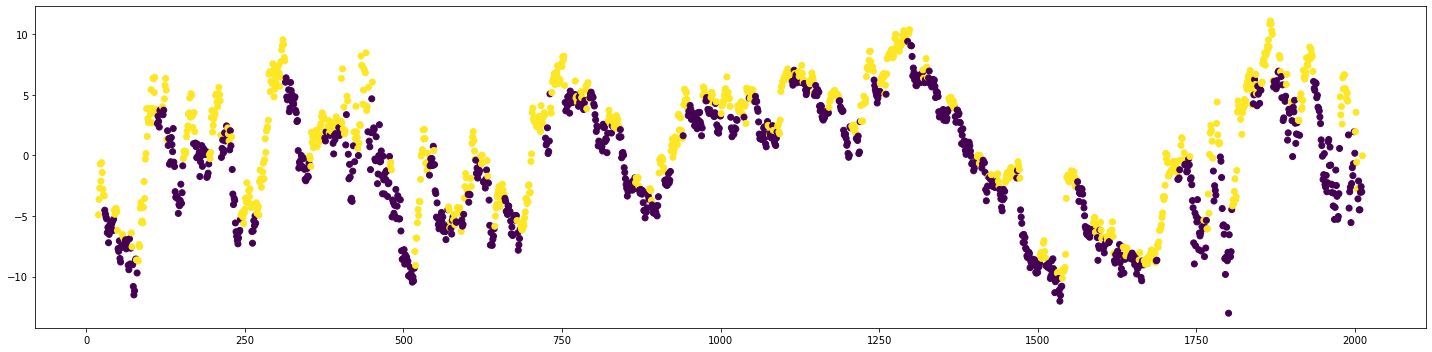

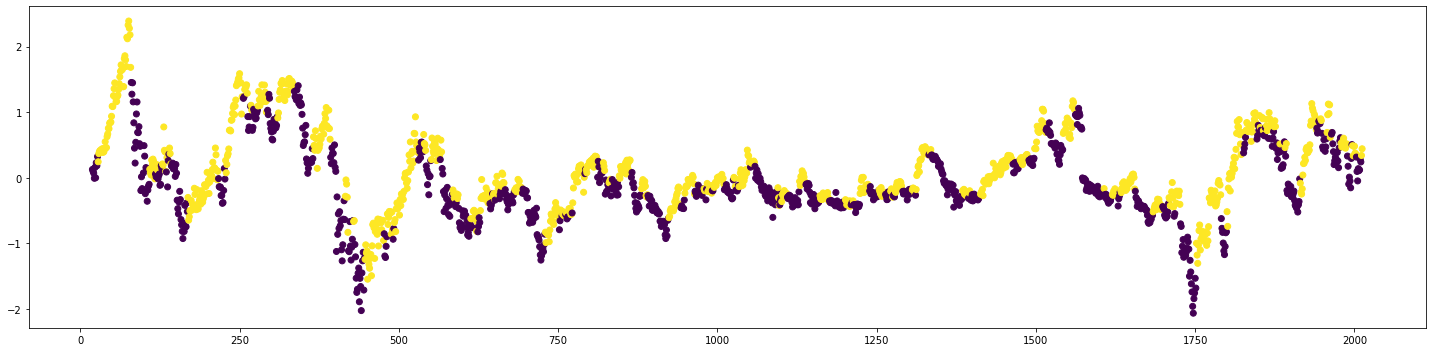

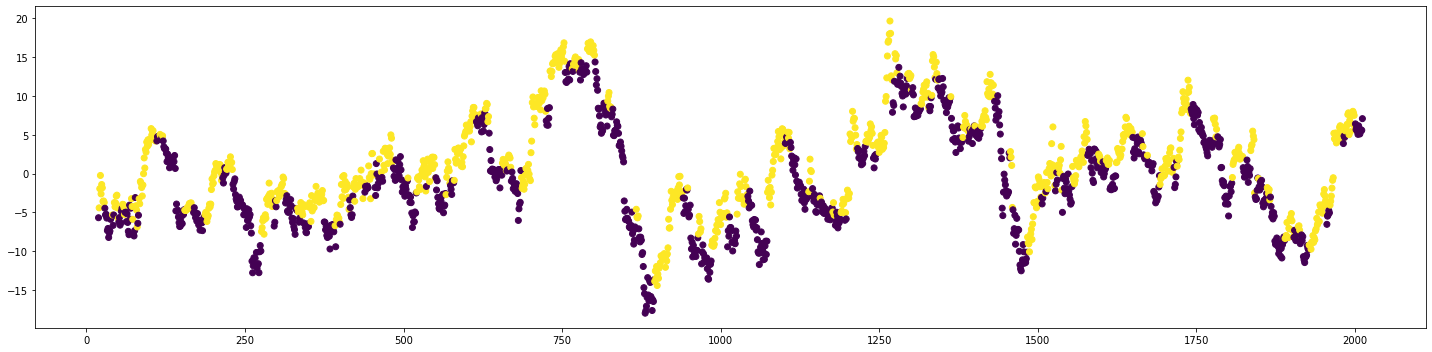

In [19]:
idx = pd.IndexSlice

for pair in filtered_pairs[:5]:
    x = range(len(cv_spreads))
    y = cv_spreads[pair]
    color = cv_trend_stats.loc[idx[:, pair], 'bin']
    
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x, y, c=color, cmap='viridis')
    fig.tight_layout()

In [20]:
bin_df = pd.DataFrame(cv_trend_stats['bin']).dropna()
bin_df.head()

bin
date       pair          
2010-02-01 ABIO-FSP  -1.0
           ADTN-FSP  -1.0
           AGNC-VIV  -1.0
           ALK-BAYRY -1.0
           APDN-CCU  -1.0

In [21]:
def get_prices_and_states(date, pair, bin_df):
    idx = pd.IndexSlice
    state_0 = bin_df.loc[idx[:, pair], 'bin'].shift(1)[date].values[0]
    state_1 = bin_df.loc[idx[date, pair], 'bin']
    securities = convertString(pair)
    security_0 = securities[0]
    security_1 = securities[1]
    
    price_0 = train.loc[date, security_0]
    price_1 = train.loc[date, security_1]
    return price_0, price_1, state_0, state_1

def create_spread_portfolio(date, bin_df,
                            pair, wealth,
                            leverage_pct, daily_interest_rate,
                            maintenance_pct, slippage_pct):
    
    # Start with initial amount of cash in hand
    cash = wealth
    leveraged_cash = cash*(1+leverage_pct) # Leverage cash
    loan = cash*leverage_pct
    short_leg_value = leveraged_cash # Dollar amount of short leg
    long_leg_value = short_leg_value # Dollar amount of long leg
 
    # Get prices and states to create portfolio
    price_0, price_1, state_0, state_1 = get_prices_and_states(date, pair, bin_df)
    
    if state_1 == 1.0:
        price_long = price_0
        price_short = price_1
        
    else:
        price_long = price_1
        price_short = price_0
    
    # Assume strategy does not get best price
    price_long_slip = price_long*(1+slippage_pct)
    price_short_slip = price_short*(1+slippage_pct)
    
    shares_long = long_leg_value/price_long_slip
    shares_short = short_leg_value/price_short_slip
    
    long_leg = shares_long*price_long
    short_leg = shares_short*price_short
    margin_account = long_leg + cash 
    maintenance_req = maintenance_pct*short_leg
    margin_call = 0.0
    
    portfolio = long_leg - short_leg
    wealth = portfolio + cash

    portfolio_dict = {'wealth':wealth,
                      'portfolio':portfolio,
                      'cash':cash,
                      'long_leg':long_leg,
                      'short_leg':short_leg,
                      'shares_long':shares_long,
                      'shares_short':shares_short,
                      'loan':loan,
                      'daily_interest_rate':daily_interest_rate,
                      'margin_account':margin_account,
                      'maintenance_req':maintenance_req,
                      'maintenance_pct':maintenance_pct,
                      'leverage_pct':leverage_pct,
                      'margin_call':margin_call,
                      'slippage_pct':slippage_pct,
                      'pair':pair,
                      'state_0':state_0,
                      'state_1':state_1}
    return portfolio_dict

def step_portfolio(date, bin_df, portfolio_dict):
    
    step_list = ['wealth', 'portfolio',
                 'long_leg', 'short_leg',
                 'shares_long', 'shares_short',
                 'maintenance_req', 'margin_account',
                 'margin_call', 'cash', 'loan',
                 'state_0', 'state_1']
    wealth = portfolio_dict['wealth']
    if wealth == 0.0:
        for item in step_list:
            portfolio_dict[item] = 0.0
        pre_margin_portfolio = portfolio_dict
        return pre_margin_portfolio
    else:
        # Get updated prices and state from portfolio dictionary
        pair = portfolio_dict['pair']
        price_0, price_1, state_0, state_1 = get_prices_and_states(date, pair, bin_df)

        if np.isnan(state_0):
            state_0 = state_1

        elif state_0 == 1.0:
            price_long = price_0
            price_short = price_1

        else:
            price_long = price_1
            price_short = price_0

        # Calculate portfolio leg values
        shares_long = portfolio_dict['shares_long']
        shares_short = portfolio_dict['shares_short']
        long_leg = shares_long*price_long
        short_leg = shares_short*price_short

        # Calculate total margin required and margin call
        maintenance_pct = portfolio_dict['maintenance_pct']
        maintenance_req = maintenance_pct*short_leg
        cash = portfolio_dict['cash']
        margin_account = long_leg + cash
        margin_call = max(0.0, maintenance_req - margin_account)

        # Calculate portfolio value
        portfolio = long_leg - short_leg
        loan = portfolio_dict['loan']
        daily_interest_rate = portfolio_dict['daily_interest_rate']
        interest = loan * daily_interest_rate
        cash = portfolio_dict['cash']
        cash = cash - interest
        wealth = max(0.0, portfolio + cash)

        # Update portfolio dictionary
        for item in step_list:
            portfolio_dict[item] = eval(item)

        pre_margin_portfolio = portfolio_dict
        return pre_margin_portfolio

def margin_call_rebalance(date, bin_df, pre_margin_portfolio):

    # Reduce wealth
    margin_call = pre_margin_portfolio['margin_call']
    wealth = pre_margin_portfolio['wealth']
    wealth = wealth - margin_call

    # Load additional data to create new spread portfolio
    pair = pre_margin_portfolio['pair']
    slippage_pct = pre_margin_portfolio['slippage_pct']
    
    # Create spread portfolio
    portfolio_dict = create_spread_portfolio(date, bin_df,
                                             pair, wealth,
                                             leverage_pct, daily_interest_rate,
                                             maintenance_pct, slippage_pct)
   # print('margin rebalance')
    return portfolio_dict

def step_and_rebalance_portfolio(date, bin_df, portfolio_dict):
    
    # Load pre-step portfolio information and step portfolio
    pair = portfolio_dict['pair']
    pre_margin_portfolio = step_portfolio(date, bin_df, portfolio_dict)
    
    # Check if portfolio requires a margin call
    margin_call = pre_margin_portfolio['margin_call']
    if margin_call > 0.0:
        # Margin call required
      #  print('margin call required')
        # Reduce wealth by and rebalance portfolio
        portfolio_dict = margin_call_rebalance(date, bin_df, pre_margin_portfolio)
    else:
        # No margin call required
        post_margin_portfolio = pre_margin_portfolio
        state_0 = post_margin_portfolio['state_0']
        state_1 = post_margin_portfolio['state_1']
        if state_0 == state_1:
            portfolio_dict = post_margin_portfolio
        else:
            pair = post_margin_portfolio['pair']
            wealth = post_margin_portfolio['wealth']
            leverage_pct = post_margin_portfolio['leverage_pct']
            maintenance_pct = post_margin_portfolio['maintenance_pct']
            slippage_pct = post_margin_portfolio['slippage_pct']
            portfolio_dict = create_spread_portfolio(date, bin_df,
                                                     pair, wealth,
                                                     leverage_pct, daily_interest_rate,
                                                     maintenance_pct, slippage_pct)
    return portfolio_dict

In [22]:
try:
    portfolio_df = pd.read_csv(f'portfolio_{n_securities}_df.csv', index_col=[0,1])
    print('portfolio_df loaded')
    portfolio_df.tail()
except FileNotFoundError:
    print('Calculating portfolio_df')
    dates = bin_df.index.get_level_values(0).unique()
    wealth_list = []
    portfolio_dict_list = []
    test_filtered_pairs = filtered_pairs
    for p, pair in enumerate(test_filtered_pairs):
        temp_portoflio_dict = defaultdict(list)
        for i, date in enumerate(dates):
            if i == 0:
                wealth_0 = 1/len(test_filtered_pairs)
                leverage_pct = 0.0
                daily_interest_rate = 0.0011
                maintenance_pct = 0.4
                slippage_pct = 0.0001

                portfolio_dict = create_spread_portfolio(dates[i], bin_df,
                                                         pair, wealth_0,
                                                         leverage_pct, daily_interest_rate,
                                                         maintenance_pct, slippage_pct)
                for k, v in portfolio_dict.items():
                    temp_portoflio_dict[k].append(v)
            else:
                portfolio_dict = step_and_rebalance_portfolio(dates[i], bin_df, portfolio_dict)
                for k, v in portfolio_dict.items():
                    temp_portoflio_dict[k].append(v)
        portfolio_dict_list.append(temp_portoflio_dict)
        explode_index = pd.MultiIndex.from_product([test_filtered_pairs, dates], names=['pair', 'date']).swaplevel()
        portfolio_df = pd.json_normalize(portfolio_dict_list).apply(pd.Series.explode)
        portfolio_df.index = explode_index
        portfolio_df = portfolio_df.sort_index(0)
        portfolio_df.to_csv(f'portfolio_{n_securities}_df.csv')
        print('portfolio_df loaded')
        portfolio_df.tail()

portfolio_df loaded


In [23]:
portfolio_df.tail(10)

wealth  portfolio      cash  long_leg  short_leg  \
date       pair                                                            
2017-12-29 UNH-YORW   0.061210  -0.003494  0.064704  0.060923   0.064417   
           UVSP-TRNX  0.000000   0.000000  0.000000  0.000000   0.000000   
           WNEB-CMP   0.009237  -0.000264  0.009501  0.009500   0.009763   
           WNEB-COHU  0.020911  -0.000462  0.021374  0.021008   0.021470   
           WSBC-COHU  0.005709  -0.000013  0.005722  0.005624   0.005637   
           WSBC-SNN   0.002593  -0.000067  0.002660  0.002625   0.002692   
           WSBC-TENX  0.000000   0.000000  0.000000  0.000000   0.000000   
           YORW-COHU  0.000707  -0.000001  0.000708  0.000693   0.000694   
           YORW-STRS  0.280663   0.001450  0.279213  0.277782   0.276332   
           YORW-TENX  0.000000   0.000000  0.000000  0.000000   0.000000   

                      shares_long  shares_short  loan  daily_interest_rate  \
date       pair                                                              
2017-12-29 UNH-YORW      0.001797      0.000292   0.0               0.0011   
           UVSP-TRNX     0.000000      0.000000   0.0               0.0011   
           WNEB-CMP      0.000872      0.000135   0.0               0.0011   
           WNEB-COHU     0.000957      0.001970   0.0               0.0011   
           WSBC-COHU     0.000256      0.000139   0.0               0.0011   
           WSBC-SNN      0.000075      0.000066   0.0               0.0011   
           WSBC-TENX     0.000000      0.000000   0.0               0.0011   
           YORW-COHU     0.000020      0.000032   0.0               0.0011   
           YORW-STRS     0.009353      0.008151   0.0               0.0011   
           YORW-TENX     0.000000      0.000000   0.0               0.0011   

                      margin_account  maintenance_req  maintenance_pct  \
date       pair                                                          
2017-12-29 UNH-YORW         0.125627         0.025767              0.4   
           UVSP-TRNX        0.000000         0.000000              0.4   
           WNEB-CMP         0.019001         0.003905              0.4   
           WNEB-COHU        0.042381         0.008588              0.4   
           WSBC-COHU        0.011345         0.002255              0.4   
           WSBC-SNN         0.005285         0.001077              0.4   
           WSBC-TENX        0.000000         0.000000              0.4   
           YORW-COHU        0.001401         0.000278              0.4   
           YORW-STRS        0.556996         0.110533              0.4   
           YORW-TENX        0.000000         0.000000              0.4   

                      leverage_pct  margin_call  slippage_pct     pair.1  \
date       pair                                                            
2017-12-29 UNH-YORW            0.0          0.0        0.0001   UNH-YORW   
           UVSP-TRNX           0.0          0.0        0.0001  UVSP-TRNX   
           WNEB-CMP            0.0          0.0        0.0001   WNEB-CMP   
           WNEB-COHU           0.0          0.0        0.0001  WNEB-COHU   
           WSBC-COHU           0.0          0.0        0.0001  WSBC-COHU   
           WSBC-SNN            0.0          0.0        0.0001   WSBC-SNN   
           WSBC-TENX           0.0          0.0        0.0001  WSBC-TENX   
           YORW-COHU           0.0          0.0        0.0001  YORW-COHU   
           YORW-STRS           0.0          0.0        0.0001  YORW-STRS   
           YORW-TENX           0.0          0.0        0.0001  YORW-TENX   

                      state_0  state_1  
date       pair                         
2017-12-29 UNH-YORW      -1.0     -1.0  
           UVSP-TRNX      0.0      0.0  
           WNEB-CMP       1.0      1.0  
           WNEB-COHU     -1.0     -1.0  
           WSBC-COHU     -1.0     -1.0  
           WSBC-SNN      -1.0     -1.0  
           WSBC-TENX      0.0      0.0  
   

In [24]:
def calculate_Sharpe(wealth, N=252):
    sampleMuDaily   = pd.Series(wealth).pct_change().mean()
    sampleMuAnnual  = (sampleMuDaily + 1)**N - 1
    sampleSigDaily  = pd.Series(wealth).pct_change().std()
    sampleVarAnnual = (sampleSigDaily**2 + (sampleMuDaily+1)**2)**N - (sampleMuDaily+1)**(2*N)
    sampleSigAnnual = np.sqrt(sampleVarAnnual)
    
    Sharpe = sampleMuAnnual/sampleSigAnnual
    return Sharpe

def calculate_drawdown(wealth):
    relativeDrawdown = []
    highWater        = wealth[0]
    for i in range(len(wealth)):
        if wealth[i] > highWater:
            highWater = wealth[i]
            relativeDrawdown.append(0)
        else:
            relativeDrawdown.append(wealth[i]/highWater -1)
    relativeDrawdown = pd.Series(relativeDrawdown, index=wealth.index)
    return relativeDrawdown

def calculate_max_drawdown(wealth):
    relativeDrawdown = []
    highWater        = wealth[0]
    for i in range(len(wealth)):
        if wealth[i] > highWater:
            highWater = wealth[i]
            relativeDrawdown.append(0)
        else:
            relativeDrawdown.append(wealth[i]/highWater -1)
    relativeDrawdown = pd.Series(relativeDrawdown, index=wealth.index)
    max_drawdown = relativeDrawdown.min()
    return max_drawdown

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


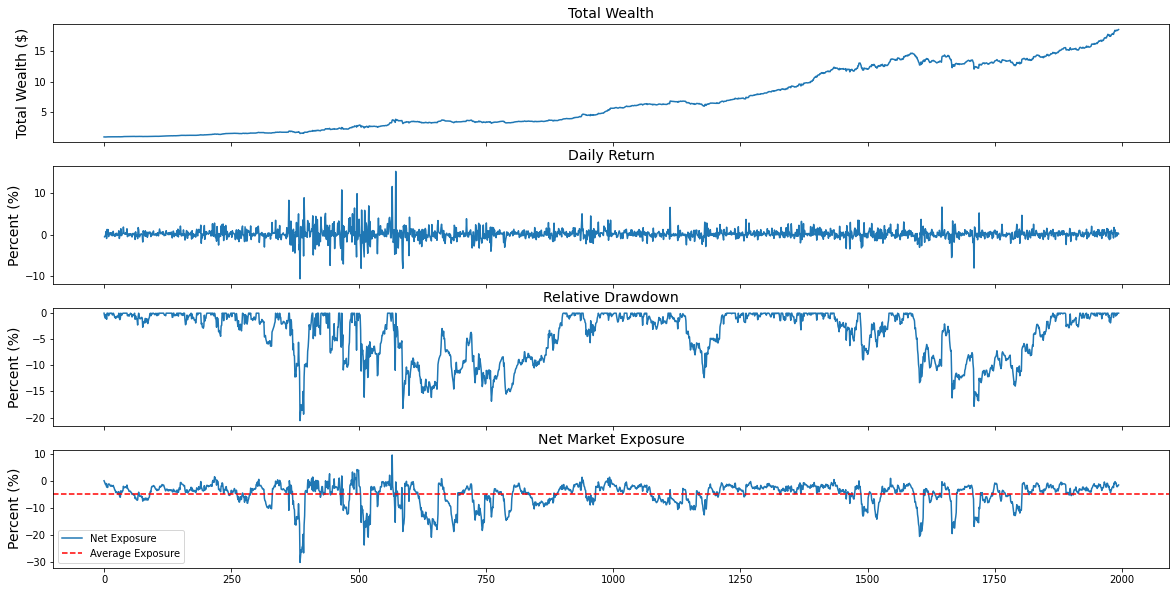

In [25]:
import matplotlib.dates as mdates
import datetime
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(20, 10))
fontsize=14

total_wealth = portfolio_df['wealth'].unstack().sum(axis=1)
axs[0].set_title('Total Wealth', fontsize=fontsize)
axs[0].plot(total_wealth.values)
axs[0].set_ylabel('Total Wealth ($)', fontsize=fontsize)

daily_returns = total_wealth.pct_change()*100
axs[1].set_title('Daily Return', fontsize=fontsize)
axs[1].plot(daily_returns.values)
axs[1].set_ylabel('Percent (%)', fontsize=fontsize)

# TODO: fix dates for bottom chart
relative_drawdown = calculate_drawdown(total_wealth)*100
# dates = [datetime.datetime.strptime(d,"%Y-%M-%d").date() for d in relative_drawdown.index]
# formatter = mdates.DateFormatter("%Y-%M-%d")
# axs[2].xaxis.set_major_formatter(formatter)
# locator = mdates.YearLocator()
# axs[2].xaxis.set_major_locator(locator)
axs[2].set_title('Relative Drawdown', fontsize=fontsize)
axs[2].plot(relative_drawdown.values)
axs[2].set_ylabel('Percent (%)', fontsize=fontsize)

net_exposure = portfolio_df['portfolio'].unstack().sum(axis=1)
net_exposure_pct = net_exposure/total_wealth*100
average_net_exposure_pct = net_exposure_pct.mean()
axs[3].set_title('Net Market Exposure', fontsize=fontsize)
axs[3].plot(net_exposure_pct.values)
axs[3].axhline(average_net_exposure_pct, ls='--', color='r', label='average')
axs[3].set_ylabel('Percent (%)', fontsize=fontsize)
axs[3].legend(['Net Exposure', 'Average Exposure'])

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


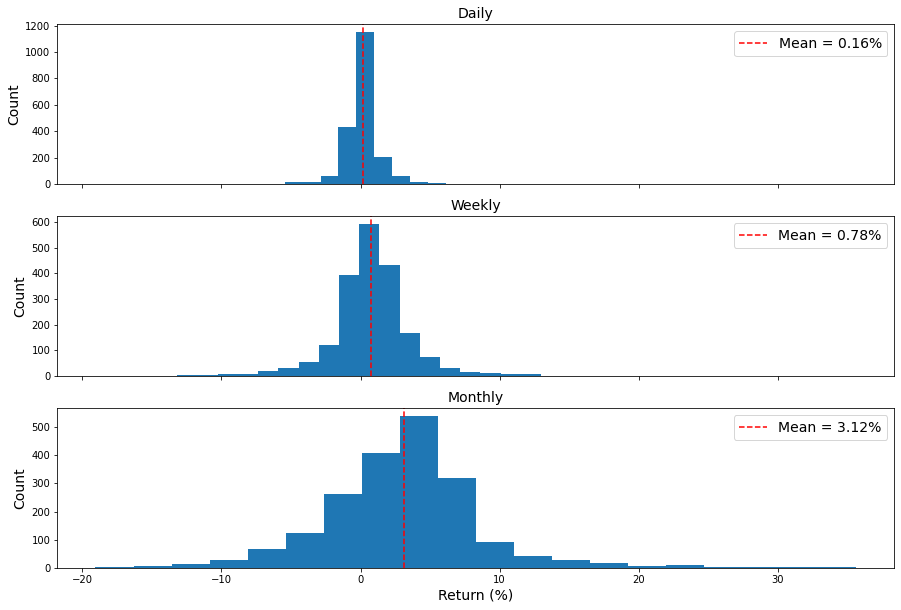

In [26]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 10))
fontsize = 14
bins = 20
total_wealth = portfolio_df['wealth'].unstack().sum(axis=1)
daily_returns = total_wealth.pct_change()*100
mean = daily_returns.mean()
axs[0].set_title('Daily', fontsize=fontsize)
axs[0].hist(daily_returns, bins=bins)
axs[0].axvline(mean, ls='--', color='r')
axs[0].set_ylabel('Count', fontsize=fontsize)
axs[0].legend([f'Mean = {round(mean, 2)}%'], fontsize=fontsize)

weekly_returns = total_wealth.pct_change(5)*100
mean = weekly_returns.mean()
axs[1].set_title('Weekly', fontsize=fontsize)
axs[1].hist(weekly_returns, bins=bins)
axs[1].axvline(mean, ls='--', color='r')
axs[1].set_ylabel('Count', fontsize=fontsize)
axs[1].legend([f'Mean = {round(mean, 2)}%'], fontsize=fontsize)

monthly_returns = total_wealth.pct_change(20)*100
mean = monthly_returns.mean()
axs[2].set_title('Monthly', fontsize=fontsize)
axs[2].hist(monthly_returns, bins=bins)
axs[2].axvline(mean, ls='--', color='r')
axs[2].set_xlabel('Return (%)', fontsize=fontsize)
axs[2].set_ylabel('Count', fontsize=fontsize)
axs[2].legend([f'Mean = {round(mean, 2)}%'], fontsize=fontsize)

fig.show()
# portfolio_df['wealth'].unstack().sum(axis=1).pct_change().hist()

In [27]:
def calculate_ann_return(wealth, N=252):
    mean_return   = pd.Series(wealth).pct_change().mean()
    ann_return  = (mean_return + 1)**N - 1
    return ann_return

def calculate_ann_std(wealth, N=252):
    sampleMuDaily   = pd.Series(wealth).pct_change().mean()
    sampleSigDaily  = pd.Series(wealth).pct_change().std()
    sampleVarAnnual = (sampleSigDaily**2 + (sampleMuDaily+1)**2)**N - (sampleMuDaily+1)**(2*N)
    sampleSigAnnual = np.sqrt(sampleVarAnnual)
    return sampleSigAnnual

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


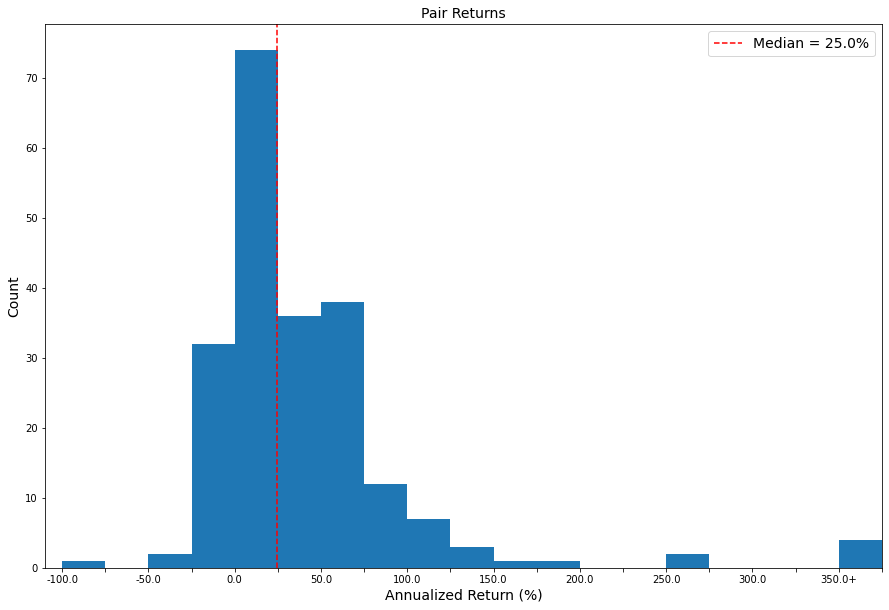

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
fontsize = 14
bins = np.arange(-1, 4, 0.25)
dates = portfolio_df.index.get_level_values(0).unique()
pair_wealth = portfolio_df['wealth'].unstack()
pair_return = pair_wealth.pct_change()
pair_mean_return = pair_return.mean()
pair_ann_return = (1+pair_mean_return)**252 - 1
median = pair_ann_return.median()
axs.set_title(f'Pair Returns', fontsize=fontsize)
axs.hist(np.clip(pair_ann_return, bins[0], bins[-1]), bins=bins)
axs.axvline(median, ls='--', color='r')
axs.legend([f'Median = {round(median, 2)*100}%'], fontsize=fontsize)
xlabels = (bins*100).astype(str)
xlabels[-2] += '+'
xlabels[1::2] = ''
N_labels = len(xlabels)
axs.set_xlim(xmin=-1.1, xmax=bins[-1])
axs.set_xticks(bins)
axs.set_xticklabels(xlabels)
axs.set_xlabel('Annualized Return (%)', fontsize=fontsize)
axs.set_ylabel('Count', fontsize=fontsize)
fig.show()

In [29]:
sp500 = yf.Ticker("^GSPC")
sp500_hist = sp500.history(period='Max')
start_date = dates[0]
end_date = dates[-1]
sp500_prices = sp500_hist.loc[start_date:end_date, 'Close']

In [31]:
grouper = pd.Grouper(freq='Y')
total_wealth.index = pd.to_datetime(total_wealth.index)
strategy_labels = ['Strategy', 'SP500']
strategy_values = [total_wealth, sp500_prices]
statistics_labels = ['Return (%)', 'Volatility (%)', 'Sharpe', 'Drawdown (%)']
statistics_functions = [calculate_ann_return, calculate_ann_std, 
                        calculate_Sharpe, calculate_max_drawdown]

calendar_summary_index = pd.MultiIndex.from_product([statistics_labels, strategy_labels],
                                              names=['statistic', 'strategy'])
calendar_summary_data = []
for function in statistics_functions:
    for strategy in strategy_values:
        calendar_data = strategy.groupby(grouper).apply(function)
        temp_dates = calendar_data.index            
        calendar_values = calendar_data.T.values

        if function != calculate_Sharpe:
            calendar_values *= 100
            
        calendar_data = [round(value, 2) for value in calendar_values]

        calendar_summary_data.append(calendar_data)
        
calendar_summary_df = pd.DataFrame(data=calendar_summary_data,
                                   index=calendar_summary_index,
                                   columns=temp_dates)
calendar_summary_df

Date                     2010-12-31  2011-12-31  2012-12-31  2013-12-31  \
statistic      strategy                                                   
Return (%)     Strategy       53.70       80.90       49.01       50.98   
               SP500          18.84        1.59       12.73       27.25   
Volatility (%) Strategy       17.55       63.14       58.73       25.91   
               SP500          21.74       23.99       14.37       13.79   
Sharpe         Strategy        3.06        1.28        0.83        1.97   
               SP500           0.87        0.07        0.89        1.98   
Drawdown (%)   Strategy       -4.43      -20.58      -18.23       -9.84   
               SP500         -15.99      -19.39       -9.94       -5.76   

Date                     2014-12-31  2015-12-31  2016-12-31  2017-12-31  
statistic      strategy                                                  
Return (%)     Strategy       38.19       67.03       12.87       42.39  
               SP500          13.16        0.51       12.23       18.84  
Volatility (%) Strategy       20.49       26.32       23.48       17.63  
               SP500          12.88       15.70       14.67        7.91  
Sharpe         Strategy        1.86        2.55        0.55        2.40  
               SP500           1.02        0.03        0.83        2.38  
Drawdown (%)   Strategy      -12.35       -8.66      -17.84       -7.30  
               SP500          -7.40      -12.35       -9.30       -2.80

In [49]:
window_summary_index = pd.MultiIndex.from_product([statistics_labels[:-1], strategy_labels],
                                                  names=['statistic', 'strategy'])

window_summary_cols = ['1-Year', '3-Year', '5-Year', '10-Year', 'Since Inception']
window_summary_data = []
for function in statistics_functions[:-1]:
    for strategy in strategy_values:
        window_values = []
        windows = [1, 3, 5, 7, len(strategy)/252]
        for window in windows:
            window_data = strategy.rolling(int(252*window)).apply(function).mean()
            if function != calculate_Sharpe:
                window_data *= 100
            window_values.append(window_data)
        window_data = [round(value, 2) for value in window_values]
        window_summary_data.append(window_data)
window_summary_df = pd.DataFrame(data=window_summary_data, 
                                 index=window_summary_index,
                                 columns=window_summary_cols)
window_summary_df

1-Year  3-Year  5-Year  10-Year  Since Inception
statistic      strategy                                                  
Return (%)     Strategy   51.48   49.71   49.70    48.09            48.37
               SP500      13.07   13.03   12.93    12.87            13.24
Volatility (%) Strategy   34.82   34.05   35.07    35.51            33.84
               SP500      15.91   16.07   16.15    16.71            16.74
Sharpe         Strategy    1.61    1.57    1.43     1.35             1.43
               SP500       0.93    0.82    0.81     0.77             0.79